In [2]:
from scripts import load_dataset
from sklearn.metrics import accuracy_score
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

In [3]:
train_ds, _ = load_dataset.load_dataset(
    "../../../German_newspaper_articles/10kGNAD/train.csv",
    "../../../German_newspaper_articles/10kGNAD/test.csv",
)

In [12]:
CATEGORY_FORMAT = "Klassifiziere nachfolgenden Artikel in eine der folgendenen Kategorien: Web, International, Etat, Wirtschaft, Panorama, Sport, Wissenschaft, Kultur oder Inland:\n"

train_ds = train_ds.map(lambda x: {"text": CATEGORY_FORMAT + x["text"]})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/9245 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [13]:
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-base")

In [14]:
generation_config = GenerationConfig.from_pretrained(
    "google-t5/t5-base", max_new_tokens=5
)

/Users/Malte/Documents/Technische Informatik /Forschungsprojekt/TextClassifier/.venv.nosync/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
model.generation_config = generation_config
model.generation_config

GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "max_new_tokens": 5,
  "pad_token_id": 0
}

In [16]:
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-base")

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

In [19]:
train_ds = train_ds.map(
    lambda x: tokenizer(
        x["text"], truncation=True, padding="max_length", max_length=512
    )
)
train_ds = train_ds.map(
    lambda y: {
        "labels": tokenizer(
            y["label"], truncation=True, padding="max_length", max_length=5
        )["input_ids"]
    }
).remove_columns("label")

Map:   0%|          | 0/9245 [00:00<?, ? examples/s]

Map:   0%|          | 0/9245 [00:00<?, ? examples/s]

In [22]:
train_split = train_ds.train_test_split(test_size=0.2)
train_ds = train_split["train"]
eval_ds = train_split["test"]

In [24]:
def compute_metrics(eval_preds):
    preds, eval = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(eval, skip_special_tokens=True)
    label_ids = [
        load_dataset.label_to_id[decoded_label] for decoded_label in decoded_labels
    ]
    pred_ids = []
    for decoded_pred in decoded_preds:
        if decoded_pred in load_dataset.label_to_id:
            pred_ids.append(load_dataset.label_to_id[decoded_pred])
        else:
            pred_ids.append(-1)

    return {"accuracy": accuracy_score(pred_ids, label_ids)}

In [26]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    logging_steps=500,
    save_steps=500,
    eval_steps=500,
    warmup_steps=2000,
    max_steps=10000,
    save_total_limit=1,
)

In [27]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_ds.with_format("torch"),
    eval_dataset=eval_ds.with_format("torch"),
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/Users/Malte/Documents/Technische Informatik /Forschungsprojekt/TextClassifier/.venv.nosync/lib/python3.11/site-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

In [ ]:
inputs = tokenizer(
    [
        "Klassifiziere nachfolgenden Artikel in eine der folgendenen Kategorien: Web, International, Etat, Wirtschaft, Panorama, Sport, Wissenschaft, Kultur oder Inland:\nDie Aktien von Tesla sind 5% gefallen"
    ],
    return_tensors="pt",
)
outputs = model.generate(**inputs)

In [ ]:
tokenizer.batch_decode(outputs, skip_special_tokens=True)

## Training stats

In [2]:
import json


def get_training_stats(training_state: str) -> tuple[list, list, list, list]:
    eval_loss = []
    train_loss = []
    eval_accuracy = []
    steps = []
    with open(training_state + "/trainer_state.json") as f:
        metrics = json.load(f)
        log_history = metrics["log_history"]

        for log in log_history:
            if "eval_loss" in log:
                eval_loss.append(log["eval_loss"])
                steps.append(log["step"])
            if "loss" in log:
                train_loss.append(log["loss"])
            if "eval_accuracy" in log:
                eval_accuracy.append(log["eval_accuracy"])
    return eval_loss, train_loss, eval_accuracy, steps

In [4]:
path_to_save_metrics = "/Users/Malte/Documents/Technische Informatik /Forschungsprojekt/TextClassifier/results/t5_results/transformer/Checkpoint.nosync"
eval_loss, train_loss, eval_accuracy, steps = get_training_stats(path_to_save_metrics)

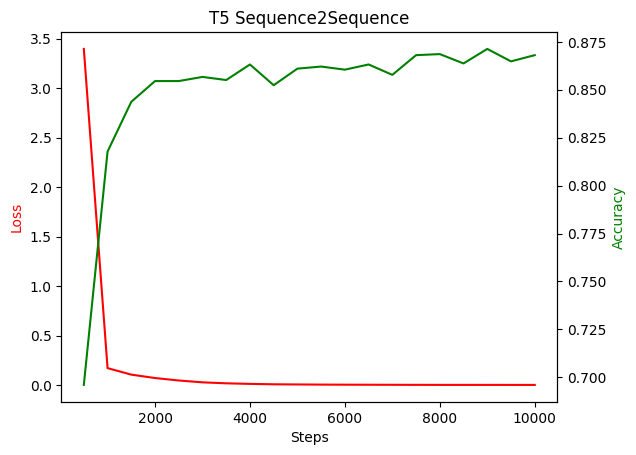

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.gca().ticklabel_format(axis="both", style="plain", useOffset=False)
ax1.plot(steps, train_loss, "r-")
ax2.plot(steps, eval_accuracy, "g-")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss", color="r")
ax2.set_ylabel("Accuracy", color="g")

plt.title("T5 Sequence2Sequence")

plt.savefig(path_to_save_metrics + "/training.png")
plt.show()